# Notebook 3: Model Training, Evaluation & Selection

# Part 1 - DEFINE
***

### Define the problem

I'll develop a few predictive models, namely, random forest, xgboost and lightgbm regression models and compare the performance of these models against the baseline with the aim to get better predictive performance. The implementation of similar models will potentially allow housing agencies, real-estate companies, banks, municipial governments and home buyers to make informed decisions with respect to market pricing.

### Objective: 
- To build a predictive ML model with the MAE accuracy of less than 20000.



### Check versions of the Python and some key packages to ensure most recent version is used

In [1]:
%load_ext watermark
%watermark -a 'Vusal Babashov' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Author: Vusal Babashov

Last updated: 2021-04-01

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.21.0

numpy     : 1.19.2
mlxtend   : 0.18.0
matplotlib: 3.3.4
sklearn   : 0.24.1



## Part 2 - DISCOVER
***

### Import Libraries

In [2]:
import pandas as pd
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline


from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from feature_engine import encoding as enc #RareLabelEncoder, OrdinalEncoder
from feature_engine.selection import SelectByTargetMeanPerformance, DropConstantFeatures, DropFeatures 
from feature_engine.imputation import MeanMedianImputer
from feature_engine.creation import CombineWithReferenceFeature, MathematicalCombination

#your info here
__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"
__website__ = 'https://vbabashov.github.io'

### Create pre-processing functions

In [3]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def log_transform (df):
    '''This function performs the log transformation of the target'''
    df['SalePrice'] = np.log(df['SalePrice'])
    return df

def drop_missing_cols_df (df):
    '''Identifies and drops the columns with 80% or hihgher proportion of missing data '''
    dropped_cols = []  
    for col in df.columns:
        if df[col].isnull().sum()/df.shape[0] >= 0.8:
            dropped_cols.append(col)
    dropped_df=df.drop(columns=dropped_cols)
    return dropped_df, dropped_cols  

def impute_missing_values (df, categorical_features, numeric_features):
    ''' Imputes the continious columns with median and categorical columns with the mode value'''
    imputer_con = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    for col in categorical_features+numeric_features:
        if df[col].isnull().sum() > 0:    
            if col in categorical_features:              
                df[col] = imputer_cat.fit_transform(df[col].values.reshape(-1,1))
            elif col in numeric_features:  
                df[col] = imputer_con.fit_transform(df[col].values.reshape(-1,1))
    return df  


def ordinal_encoding (df, ord_cols, ordinal_categories_list):
    '''This function encodes ordinal variables into ordinal encoding and combines wit the rest of the dataframe'''
    encoder = OrdinalEncoder(categories=ordinal_categories_list)
    df[ord_cols] = encoder.fit_transform(df[ord_cols])
    return df


def convert_data_types (df):
    '''This function coverts the categorical variables into object and numeric variables into int types'''
    df[nominal] = df[nominal].astype('O')
    df[ordinal] = df[ordinal].astype('int')
    df[numeric] = df[numeric].astype('int') 
    return df

def convert_month_string (df):
    '''This function maps the numerical month names into string month names'''
    d = { 1 : 'Jan',
          2 : 'Feb',
          3 : 'Mar',
          4 : 'Apr',
          5 : 'May',
          6 : 'June',
          7 : 'July',
          8 : 'Aug',
          9 : 'Sep',
          10: 'Oct',
          11: 'Nov',
          12: 'Dec'
    }
    df['MoSold'] = df ['MoSold'].map(d)
    return df

### Load the Data

In [4]:
train_file = "/Users/vusalbabashov/Desktop/house-prices/data/raw/train.csv"
test_feature_file = "/Users/vusalbabashov/Desktop/house-prices/data/raw/test.csv"

data_train_raw = load_file(train_file)
feature_pred_raw  = load_file(test_feature_file)

To understand the data better, the full [EDA](https://github.com/vbabashov/house-prices/blob/main/notebooks/EDA.ipynb) analysis are implemented in seperate notebooks due to size and readibility. 

### PreProcessing Steps

In [5]:
train_transformed = log_transform(data_train_raw) # Log transformation of the target

In [6]:
train_clean, missing_cols = drop_missing_cols_df(train_transformed) # determine and drop the missing columns with 80% or more proportion

In [7]:
missing_cols # These four columns are dropped

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
pred_clean = feature_pred_raw.drop(columns=missing_cols, axis=1) # Let's drop the same columns from the test set

In [9]:
nominal = ['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 
                   'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                   'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MoSold',
                   'SaleType', 'SaleCondition'] # removed Alley, MiscFeature, 

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
                   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                   'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
                   'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'PavedDrive'] #removed PoolQC, Fence,


numeric = ['Id','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
                  'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                  'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd',
                  'Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscVal', 'GarageYrBlt', 'YrSold'] # removed the SalePrice

categorical = nominal+ordinal

In [10]:
train_imputed = impute_missing_values (train_clean, categorical, numeric)  #impute the categorical variables with the most frequent, or mode, and the numeric variables with the median
pred_imputed = impute_missing_values (pred_clean, categorical, numeric) 

 Below are ordered values for each ordinal variable as per the data dictionary.

In [11]:
# Ordinal Category Values
lot_shape = ['IR3','IR2','IR1','Reg']
utilities = ['ELO', 'NoSeWa', 'NoSewr','AllPub']
land_slope = ['Sev','Mod','Gtl']
overall_qual = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # already in the ordinal structure
overall_cond = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # already in the ordinal structure
exter_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
exter_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_qual  = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_cond  = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_exposure  = ['NA', 'No', 'Mn', 'Av', 'Gd']
bsmt_fin_type1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmt_fin_type2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
heating_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
electrical = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
kitchen_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
functional = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
fire_place_qual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
garage_finish = ['NA', 'Unf', 'RFn', 'Fin']
garage_qual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
garage_cond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
paved_drive = ['N', 'P', 'Y']

ordinal_categories_list = [lot_shape , utilities, land_slope, overall_qual, overall_cond, exter_qual, exter_cond, bsmt_qual, 
                          bsmt_cond, bsmt_exposure, bsmt_fin_type1, bsmt_fin_type2, heating_qual, electrical, kitchen_qual,
                          functional, fire_place_qual, garage_finish, garage_qual, garage_cond, paved_drive]  

In [12]:
train_converted = convert_month_string(train_imputed)
pred_converted  = convert_month_string(pred_imputed)

In [13]:
train_enc  =   ordinal_encoding (train_converted, ordinal, ordinal_categories_list) # encode the ordinal variables as per specified orderd
pred_enc   =   ordinal_encoding (pred_converted, ordinal, ordinal_categories_list)

In [14]:
train_df = convert_data_types (train_enc)
pred_df  = convert_data_types (pred_enc)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Id', 'SalePrice'], axis=1),train_df['SalePrice'],
                                                    test_size=0.2,
                                                    random_state=0)

X_pred = pred_df.drop(columns=['Id'], axis=1)

X_entire = train_df.drop(['Id', 'SalePrice'], axis=1)
y_entire = train_df['SalePrice']

X_train.shape, X_test.shape, X_pred.shape, X_entire.shape

((1168, 75), (292, 75), (1459, 75), (1460, 75))

### Establish a baseline 

In a seperate notebook, I used Ordinary Least Squares (OLS) Regression model results as a [baseline](https://github.com/vbabashov/house-prices/blob/main/notebooks/baseline.ipynb) and obtained the following model accuracy.

- MAE  for the Baseline Model: 24139.18
- RMSE for the Baseline Model : 149478.70

### Hypothesize solution 

Th MAE is around 24000 with the engineered features. Let's try to come up with a predictive model with better accuracy. There are many supervised learning methods that can be developed. In this notebook, I'll explore the following tree-based techniques because of their recent successful applications in many domains.

- Random Forest
- Xgboost 
- LightGBM

## Part 3 - DEVELOP

In this part of the process, I'll look into creating features, tuning models, and training/validating models
- model selection (i.e, hyperparameter tuning)
- algorithm selection
- model evaluation with the selected algorithm

### Feature Engineering

In [16]:
def engineer_features (feature_df, target_df):
    
    rare_encoder = enc.RareLabelEncoder(tol = 0.05, n_categories=4, variables=nominal)
    price_encoder = enc.OrdinalEncoder (encoding_method='ordered', variables = nominal)
    
    age = CombineWithReferenceFeature(
        variables_to_combine=['YrSold'],
        reference_variables=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'],
        operations = ['sub']
    )     
   
    bath = MathematicalCombination(
        variables_to_combine=['BsmtHalfBath', 'BsmtFullBath', 'FullBath', 'HalfBath'],
        math_operations=['sum'],
        new_variables_names=['TotalBath'],
    )
    
    area = MathematicalCombination(
        variables_to_combine=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],
        math_operations=['sum'],
        new_variables_names=['TotalArea'],
    )
    
    drop = DropFeatures(
        features_to_drop=['YearBuilt','YrSold','YearRemodAdd', 'GarageYrBlt']
    )
    
    pipe = Pipeline(steps=[ 
                            ('rare_encoder', rare_encoder), 
                            ('ordinal_encoder', price_encoder),
                            ('cobinator',age),
                            ('bath', bath),
                            ('area', area),
                            ('drop', drop)
                        ])
      
    pipe.fit(feature_df, target_df)  
    
    return pipe

pipeline = engineer_features (X_train, y_train)

In [17]:
X_train  = pipeline.transform(X_train)

In [18]:
X_test   = pipeline.transform(X_test)

In [19]:
X_pred   = pipeline.transform(X_pred)

In [20]:
X_entire = pipeline.transform(X_entire)

### Compare the Models, With Different Parameters, and Algorithms Using Nested Cross Validation (i.e., 5x2Cv)

In [21]:
reg1 = RandomForestRegressor(random_state=1)
reg2 = XGBRegressor(random_state=1)
reg3 = LGBMRegressor(random_state=1)

In [22]:
def build_pipelines_grids (reg1, reg2, reg3): 
    '''This function returns the pipelines and parameter grids''' 
    # Building the Pipelines
    pipe1 = Pipeline(steps=[ 
                            #('pol', PolynomialFeatures()), 
                            #('sel', SelectKBest(score_func=f_regression)),
                            ('reg1',reg1)])

    pipe2 = Pipeline(steps=[
                            #('pol', PolynomialFeatures()), 
                            #('sel', SelectKBest(score_func=f_regression)),
                            ('reg2',reg2)])

    pipe3 = Pipeline(steps=[
                            #('pol', PolynomialFeatures()),                     
                            #('sel', SelectKBest(score_func=f_regression)),
                            ('reg3',reg3)])
    
   # Setting up the parameter grids for hyperparameter tuning, i.e, Model Selection
    param_grid1 = {'reg1__n_estimators': [500,1000],
                   #'sel__k': [40,60,75]
                   }

    param_grid2 = {
                  'reg2__colsample_bytree':[0.6, 0.8], 
                  'reg2__max_depth': [8,10],
                  'reg2__min_child_weight':[3,7], 
                  'reg2__subsample' :[0.6, 0.8],
                  #'sel__k': [40,60,75]
                 }

    param_grid3 = {
                    "reg3__num_leaves": [6, 8, 20, 30],
                    "reg3__max_depth": [2, 4, 6, 8, 10],
                    "reg3__n_estimators": [50, 100, 200, 500],
                    "reg3__colsample_bytree": [0.3, 1.0],
                   # 'sel__k': [40,60,75]
               }
    
    return pipe1, pipe2, pipe3, param_grid1, param_grid2, param_grid3

In [23]:
pipe1, pipe2, pipe3, param_grid1, param_grid2, param_grid3 = build_pipelines_grids (reg1, reg2, reg3) # create pipelines and parameter grids

In [24]:
def nested_kfold_cv (pipe1, pipe2, pipe3, param_grid1, param_grid2, param_grid3, feature_train, target_train):
    '''This function performs the nested 5x2cv procedure'''
    gridcvs = {}

    inner_cv = KFold(n_splits=2, shuffle=True, random_state=1)

    for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                                (pipe1, pipe2, pipe3),
                                ('RForest', 'Xgboost', 'LightGBM')):

        gcv = GridSearchCV(estimator=est,
                           param_grid=pgrid,
                           scoring = 'neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=inner_cv,
                           verbose=0,
                           refit=True)
        gridcvs[name] = gcv
    
    
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for name, gs_est in sorted(gridcvs.items()):
        scores_dict = cross_validate(gs_est, 
                                     X=feature_train, 
                                     y=target_train,
                                     verbose=0,
                                     cv=outer_cv,
                                     return_estimator=True,
                                     n_jobs=-1
                                    )

        print(50 * '-', '\n')
        print('Algorithm:', name)
        print('    Inner loop:')


        for i in range(scores_dict['test_score'].shape[0]):

            print('\n      Best RMSE Score (avg. of inner test folds) %.2f' % np.absolute(scores_dict['estimator'][i].best_score_))
            print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
            print('        RMSE Score (on outer test fold) %.2f' % np.absolute(scores_dict['test_score'][i]))

        print('\n%s | outer test folds Ave. Score %.2f +/- %.2f' % 
              (name, np.absolute(scores_dict['test_score']).mean(), 
               np.absolute(scores_dict['test_score']).std()))    

In [25]:
nested_kfold_cv (pipe1, pipe2, pipe3, param_grid1, param_grid2, param_grid3, X_train, y_train) # nested k-fold cross validation

-------------------------------------------------- 

Algorithm: LightGBM
    Inner loop:

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parameters: Pipeline(steps=[('reg3',
                 LGBMRegressor(colsample_bytree=0.3, max_depth=6, num_leaves=6,
                               random_state=1))])
        RMSE Score (on outer test fold) 0.12

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parameters: Pipeline(steps=[('reg3',
                 LGBMRegressor(max_depth=2, n_estimators=500, num_leaves=6,
                               random_state=1))])
        RMSE Score (on outer test fold) 0.16

      Best RMSE Score (avg. of inner test folds) 0.14
        Best parameters: Pipeline(steps=[('reg3',
                 LGBMRegressor(colsample_bytree=0.3, max_depth=6, num_leaves=20,
                               random_state=1))])
        RMSE Score (on outer test fold) 0.12

      Best RMSE Score (avg. of inner test folds) 0.13
        Best parame

In [26]:
def tune_and_select_best_model (est, grid, feature_train, target_train, feature_test, target_test): 
    '''This function performs hyperparameter tuning on the whole training set and report the  model train and test accuracy'''
    gcv_model_select = GridSearchCV(estimator=est,
                                param_grid=grid,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1,
                                cv = 2,
                                verbose=0,
                                refit=True)

    gcv_model_select.fit(feature_train, target_train)
    best_model = gcv_model_select.best_estimator_

    train_ = mean_absolute_error(y_true=np.exp(target_train), y_pred=np.exp(best_model.predict(feature_train)))
    test_  = mean_absolute_error(y_true=np.exp(target_test),  y_pred=np.exp(best_model.predict(feature_test)))

    print('Best CV Score: %.2f' % np.absolute(gcv_model_select.best_score_))
    print('Best Parameters: %s' % gcv_model_select.best_params_)
    
    print('\nTrain MAE: %.2f' % (train_))
    print(' Test MAE: %.2f' % (test_))
    
    print('\nTrain R2: %.2f' % r2_score(y_true=np.exp(y_train), y_pred=np.exp(best_model.predict(X_train))))
    print(' Test R2: %.2f' %   r2_score(y_true=np.exp(y_test),  y_pred=np.exp(best_model.predict(X_test))))
    
    return best_model

In [27]:
best_model = tune_and_select_best_model (pipe3, param_grid3, X_train, y_train, X_test, y_test) # hyperparameter tuning using the Gridsearch and report train and test accuracy using the LightGBM

Best CV Score: 0.13
Best Parameters: {'reg3__colsample_bytree': 0.3, 'reg3__max_depth': 4, 'reg3__n_estimators': 100, 'reg3__num_leaves': 6}

Train MAE: 11789.50
 Test MAE: 16645.64

Train R2: 0.94
 Test R2: 0.85


## Part 4 - DEPLOY

### Automate pipeline 

In [28]:
#script that trains model on entire training set, and generate predictions on unseen test data, i.e., X_pred
#
best_model.fit(X_entire,y_entire)
predictions = np.round(np.exp(best_model.predict(X_pred)),2)

### Deploy solution

In [29]:
def save_results(model, predictions, feature_importances):
    '''saves model,  feature importances, and predictions'''
    with open('/Users/vusalbabashov/Desktop/house-prices/reports/model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('/Users/vusalbabashov/Desktop/house-prices/reports/feature_importances.csv') 
    np.savetxt('/Users/vusalbabashov/Desktop/house-prices/reports/predictions.csv', predictions, delimiter=',')

In [30]:
def store_feature_importance (model):
    ''' stores the feature importance to dataframe'''
    if hasattr(model, 'feature_importances_'):
        importances = model[0].feature_importances_
    else:
        #linear models don't have feature_importances_
        importances = [0]*len(model[0].feature_name_)
    feature_importances = pd.DataFrame({'feature': model[0].feature_name_, 'importance': model[0].feature_importances_})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    #set index to 'feature'
    feature_importances.set_index('feature', inplace=True, drop=True)      
    return feature_importances

features = store_feature_importance (best_model) # store feature importances
save_results(best_model, predictions, features) #save model, predictions and feature importances on disk

<Figure size 432x288 with 0 Axes>

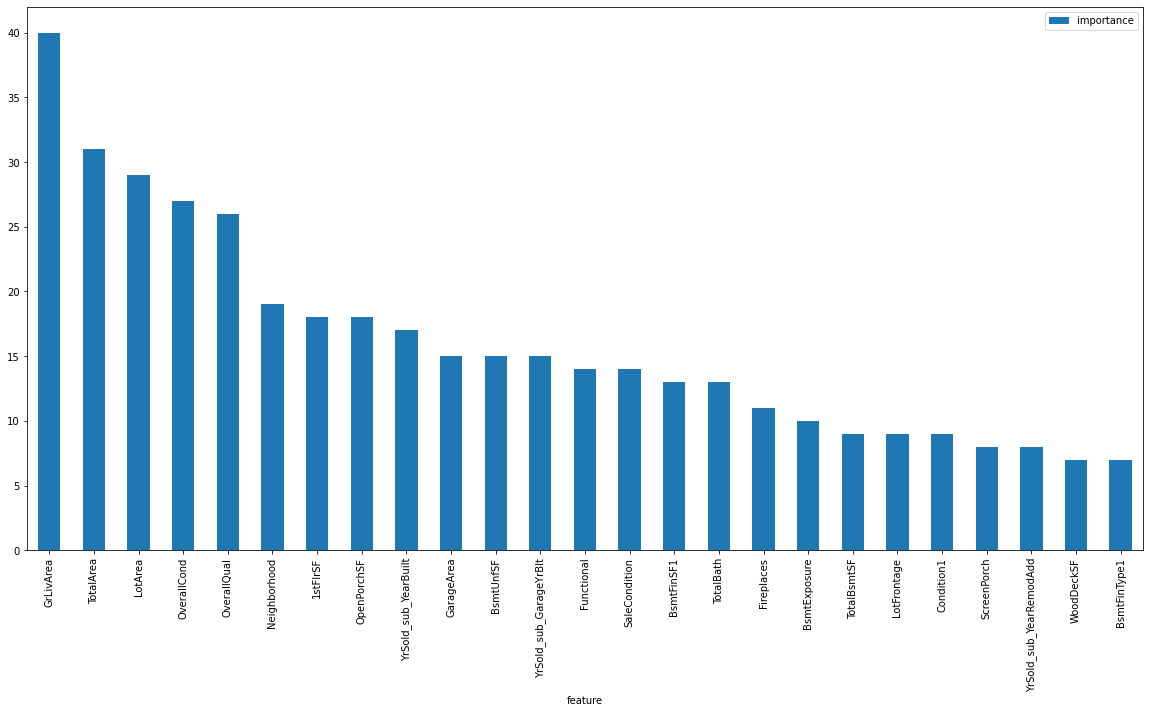

In [31]:
#create plot for the top 25 feature importances
fig = plt.figure()
features[0:25].plot.bar(figsize=(20,10))
plt.savefig('/Users/vusalbabashov/Desktop/house-prices/reports/figures/features.jpeg', bbox_inches='tight')
plt.show()

### Measure efficacy

I'll skip this step since we don't have the outcomes for the unseen test data